| **Chapter**                   | 9:  Agent-based models             |
| ----------------------------- |------------------------------------|
| **Computational Note**        | 9.x: Targeted prophylaxis          |
| **Package prerequisites**     | [Mesa](http://mesa.readthedocs.io) |

# Targeted prophylaxis


In [156]:
import numpy as np
import pandas as pd
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
from mesa import batchrunner
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import enum
import random
from typing import *


COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

In [2]:
%load_ext watermark
%watermark --iversions -v -a "Chris von Csefalvay" -gu "chrisvoncsefalvay" -p mesa

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: Chris von Csefalvay

Github username: chrisvoncsefalvay

Python implementation: CPython
Python version       : 3.10.2
IPython version      : 8.4.0

mesa: 0.9.0



In [157]:
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    INFECTED = 1
    RECOVERED = 2
    VACCINATED = 3
    DECEASED = 4

In [158]:
class Person(Agent):
    def __init__(self, uid, model):
        super().__init__(uid, model)
        
        # Naive start
        self.state = State.SUSCEPTIBLE
        self.susceptible_neighbourhood_size, self.infectious_neighbourhood_size, self.vaccinated_neighbourhood_size, self.recovered_neighbourhood_size, self.living_neighbourhood_size = 0, 0, 0, 0, 0
        
    def contact_event(self):
        neighbourhood = self.model.grid.get_neighbors(self.pos, include_center=False)
        susceptible_neighbourhood = [agent for agent in self.model.grid.get_cell_list_contents(neighbourhood) 
                                                                            if agent.state is State.SUSCEPTIBLE]

        for neighbour in susceptible_neighbourhood:
            if np.random.rand() < self.model.beta:
                neighbour.state = State.INFECTED

    def status_update(self):        
        if self.state == State.INFECTED:
            if np.random.rand() < 1/self.model.recovery_period:
                if np.random.rand() < self.model.CFR:
                    self.state = State.DECEASED
                else:
                    self.state = State.RECOVERED

        if np.random.rand() < self.model.base_mortality_rate:
            self.state = State.DECEASED

        neighbourhood = self.model.grid.get_cell_list_contents(self.model.grid.get_neighbors(self.pos, include_center=False))
        self.susceptible_neighbourhood_size = sum(1 for agent in neighbourhood if agent.state is State.SUSCEPTIBLE)
        self.infectious_neighbourhood_size = sum(1 for agent in neighbourhood if agent.state is State.INFECTED)
        self.vaccinated_neighbourhood_size = sum(1 for agent in neighbourhood if agent.state is State.VACCINATED)
        self.living_neighbourhood_size = sum(1 for agent in neighbourhood if agent.state is not State.DECEASED)

    def step(self):
        self.status_update()

        if self.state is State.INFECTED:
            self.contact_event()
    

In [159]:
class NetworkInfectiousDiseaseModel(Model):

    def __init__(self, 
                 nodes=5000, 
                 mean_degree=12,
                 recovery_period=4,
                 beta=0.02,
                 CFR=0.05,
                 base_mortality_rate=0.000125,
                 I0=0.0025,
                 policy="random",
                 vaccines_per_step_limit=150):
                     
        self.N_agents = nodes
        self.recovery_period = recovery_period
        self.beta = beta
        self.CFR = CFR
        self.base_mortality_rate = base_mortality_rate

        self.graph = nx.barabasi_albert_graph(n=self.N_agents, m=mean_degree)
        self.grid = NetworkGrid(self.graph)

        self.schedule = RandomActivation(self)
        self.running = True
        self.policy = policy
        self.vaccines_per_step_limit = vaccines_per_step_limit

        self.policy_names = {
            "random": self.vaccinate_randomly,
            "susceptibility": self.vaccinate_by_number_of_susceptible_connections,
            "risk": self.vaccinate_at_highest_risk,
            "equity": self.vaccinate_by_equity
        }

        for idx, node in enumerate(self.graph.nodes()):
            agent = Person(uid=idx + 1, model=self)
            self.schedule.add(agent)
            self.grid.place_agent(agent, node)

            if idx < I0 * nodes:
                agent.state = State.INFECTED

        self.datacollector = DataCollector({"Infectious": lambda m: m.number_infectious()})


    def get_susceptibles(self) -> List[Agent]:
        return [agent for agent in self.schedule.agents if agent.state is State.SUSCEPTIBLE]

    def vaccinate_randomly(self, n: int):
        for vaccinee in random.sample(self.get_susceptibles(), min(n, len(self.get_susceptibles()))):
            vaccinee.state = State.VACCINATED

    def vaccinate_by_number_of_susceptible_connections(self, n: int):
        candidates = self.get_susceptibles().sort(key=lambda x: x.susceptible_neighbourhood_size, reverse=True)
        if candidates:
            for i in candidates[:n]:
                i.state = State.VACCINATED

    def vaccinate_at_highest_risk(self, n: int):
        candidates = self.get_susceptibles().sort(key=lambda x: x.infectious_neighbourhood_size/(x.living_neighbourhood_size + 1), reverse=True)
        if candidates:
            for i in candidates[:n]:
                i.state = State.VACCINATED
    
    def vaccinate_by_equity(self, n: int):
        candidates = self.get_susceptibles().sort(key=lambda x: x.vaccinated_neighbourhood_size/(x.living_neighbourhood_size+1))
        if candidates:
            for i in candidates[:n]:
                i.state = State.VACCINATED

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self.policy_names[self.policy](self.vaccines_per_step_limit)

    def number_infectious(self):
        return np.sum([1 for i in self.schedule.agents if i.state is State.INFECTED])

In [160]:
br = batchrunner.FixedBatchRunner(NetworkInfectiousDiseaseModel,
                                  fixed_parameters={"nodes": 5000},
                                  parameters_list=[{"policy": "random"}, {"policy": "susceptibility"}, {"policy": "risk"}, {"policy": "equity"}],
                                  iterations=2,
                                  max_steps=120,
                                  model_reporters={"vals": lambda m: m.datacollector},
                                  display_progress=True)

In [161]:
br.run_all()

8it [04:59, 37.44s/it]


In [162]:
by_policy = {}

for i in range(len(br.get_model_vars_dataframe().policy)):
    if br.get_model_vars_dataframe().policy[i] not in by_policy.keys():
        by_policy[br.get_model_vars_dataframe().policy[i]] = []
    
    by_policy[br.get_model_vars_dataframe().policy[i]].append(
        br.get_model_vars_dataframe().vals[i].get_model_vars_dataframe()["Infectious"]
    )

In [163]:
means, sds = {}, {}

for i in br.get_model_vars_dataframe().policy.unique():
    mu = pd.concat([*(by_policy[i])], axis=1).mean(axis=1)
    sigma = pd.concat([*(by_policy[i])], axis=1).std(axis=1)

    means[i] = mu
    sds[i] = sigma

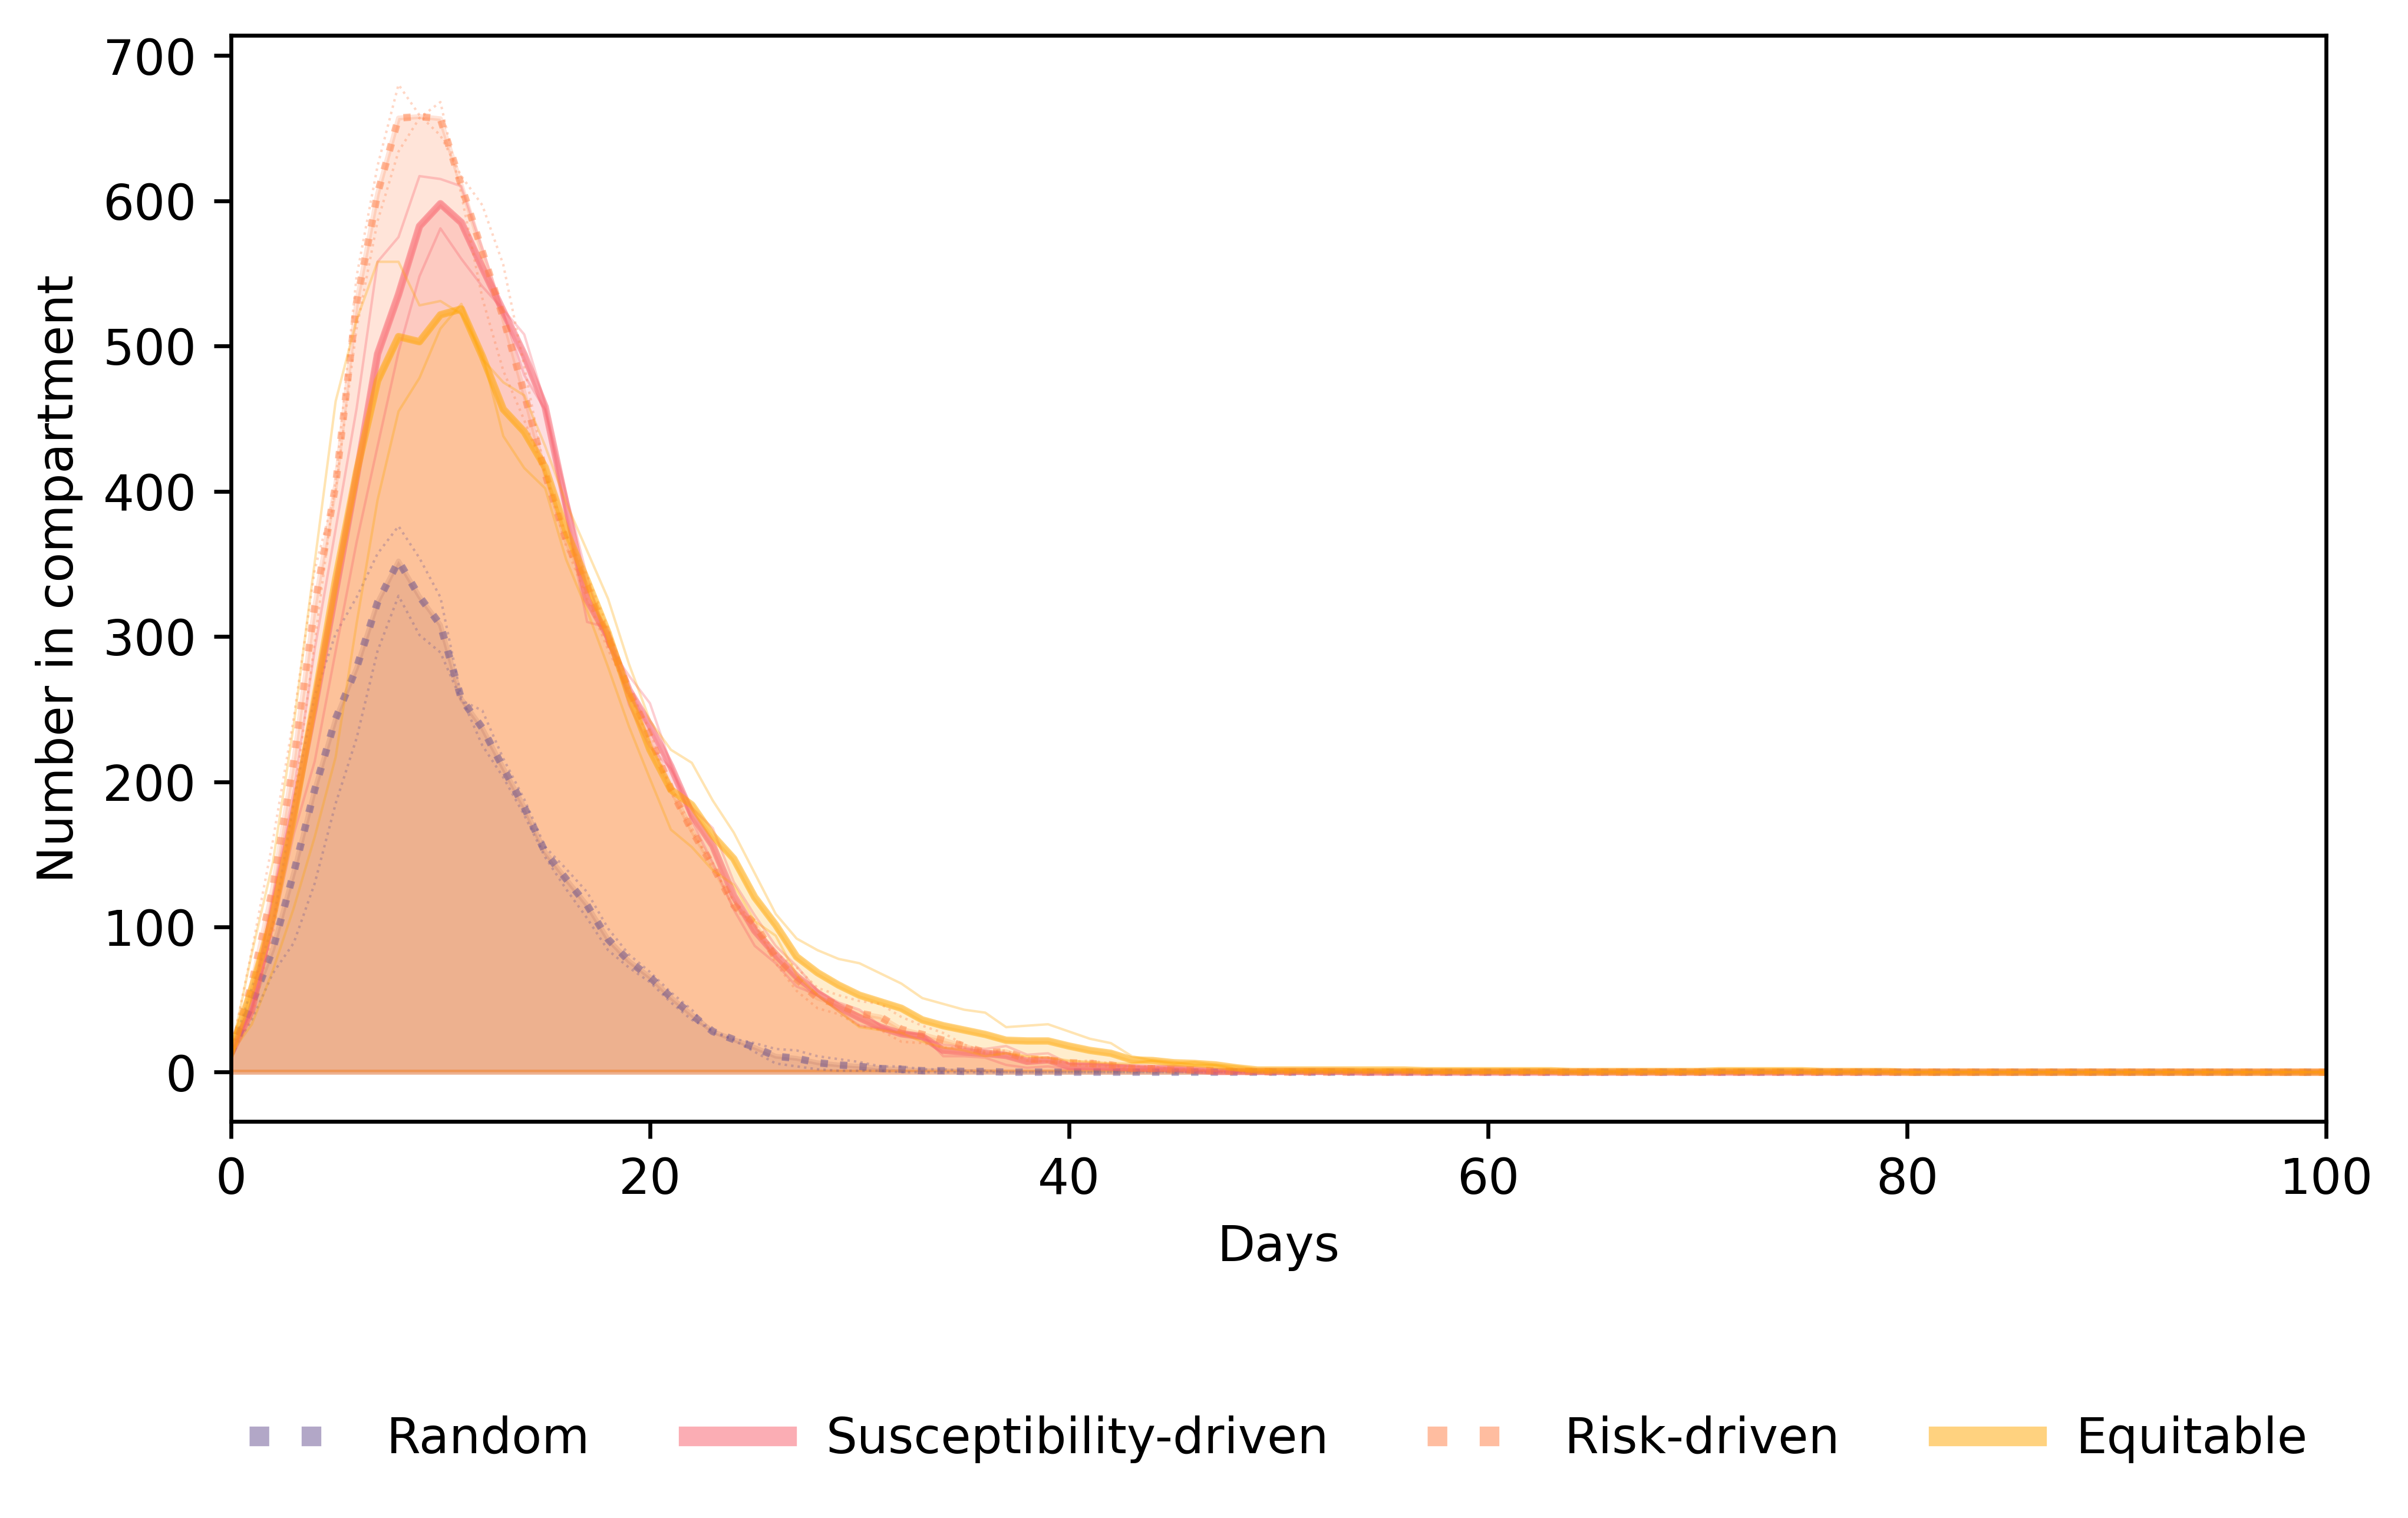

In [166]:
fig = plt.figure(facecolor="w", figsize=(8, 6), dpi=600)
ax = fig.add_subplot(111, axisbelow=True)

colour_cycle = ["X", "I", "C", "E"]

logged_qs = []
linestyle_idx = 0

for idx, q in enumerate(by_policy.keys()):
    for ts in by_policy[q]:
        ax.plot(ts, color=COLORS[colour_cycle[idx]], alpha=0.3, lw=0.5, label="", linestyle=":" if linestyle_idx % 2 == 0 else "solid")
        logged_qs.append(q)

    ax.plot(means[q], color=COLORS[colour_cycle[idx]], lw=1.5, alpha=0.5, linestyle=":" if linestyle_idx % 2 == 0 else "solid")
    ax.fill_between(ts.index, means[q], 0, color=COLORS[colour_cycle[idx]], alpha=0.2)
    linestyle_idx += 1

legend_lines = [Line2D([0], [0], color=COLORS["X"], lw=4, alpha=0.5, linestyle=":"),
                Line2D([0], [0], color=COLORS["I"], lw=4, alpha=0.5, linestyle="solid"),
                Line2D([0], [0], color=COLORS["C"], lw=4, alpha=0.5, linestyle=":"),
                Line2D([0], [0], color=COLORS["E"], lw=4, alpha=0.5, linestyle="solid")]

ax.legend(legend_lines, ["Random", "Susceptibility-driven", "Risk-driven", "Equitable"], title="", bbox_to_anchor=(0.5, -0.355), loc="lower center", ncol=4, frameon=False)

ax.set_xlim(0, 100)
ax.set_xlabel("Days")
ax.set_ylabel("Number in compartment")

fig.tight_layout(pad=5.0)
plt.savefig("vax_policies.pdf")
plt.show()